In [1]:
using Plots
#using Interact
using Distributions
using RandomMatrices

In [129]:
function tw_pdf(xs, step)
    c = cdf(TracyWidom, vcat(vcat(xs[1]-step,xs),xs[end]+step))
    d = (diff(c)[1:end-1]+diff(c)[2:end]) / (2*step)
    return d
end

step = 0.1
min_, max_ = -6, 6
xs = min_:step:max_
TW_pdf = tw_pdf(xs, step);

In [229]:
function G(couple, wait)
    i, j = couple[1], couple[2]
    if(i==1 && j==1)
        return 0
    elseif(i==1)
        return G((i, j-1), wait) + wait[i, j]
    elseif(j==1)
        return G((i-1, j), wait) + wait[i, j]
    else
        return max(G((i, j-1), wait), G((i-1, j), wait)) + wait[i, j]
    end
end

function m_G(wait)
    N = size(wait)[1]
    memg = zeros(N, N) .- 1 #trunc.(Int, zeros(N,N)) .- 1
    memg[1, 1] = 0
    for i in 1:N
        memg[i, 1] = 0
        memg[1, i] = 0
    end
    function tmp_G(i, j, wait)
        if(memg[i, j] == -1)
#             if(i==1)
#                 res1 = tmp_G(i, j-1, wait)
#                 memg[i, j-1] = res1
#                 res = res1 + wait[i, j] #+1
#             elseif(j==1)
#                 res1 = tmp_G(i-1, j, wait)
#                 memg[i-1, j] = res1
#                 res = res1 + wait[i, j] #+1
#             else
            res1 = tmp_G(i, j-1, wait)
            res2 = tmp_G(i-1, j, wait)
            memg[i, j-1] = res1
            memg[i-1, j] = res2
            res = max(res1, res2) + wait[i, j] #+1
#             end
            memg[i, j] = res
        end
        return memg[i, j]
    end
    tmp_G(N, N, wait)
    return memg
end

m_G (generic function with 1 method)

In [279]:
law = Geometric(0.5)

res = Float64[]
N = 200
for i in 1:2000
    w = rand(law, N+1, N+1);
    tnn = m_G(w)[N+1, N+1]
    append!(res, tnn)
end 

In [225]:
## http://www.math.cmu.edu/~eemrah/CGM_TW.pdf
## https://www.math.utah.edu/~firas/FPD16/Talks/Emrah.pdf
## https://arxiv.org/pdf/math/9903134.pdf
## https://arxiv.org/pdf/1612.08521.pdf

r = 1

if typeof(law) == Geometric{Float64}
    q = params(law)[1]
    γ = (q*(1+r) + 2*√(q*r)) / (1-q)
    σ = (1/(1-q)) * (q/r)^(1/6) * (√q + √r)^(2/3) * (1 + √(q*r))^(2/3)
elseif typeof(law) == Exponential{Float64}
    λ = 1 / params(law)[1]
    γ = (1+√r)^2 / λ
    σ = r^(-1/6) * (1+r)^(4/3)
end;

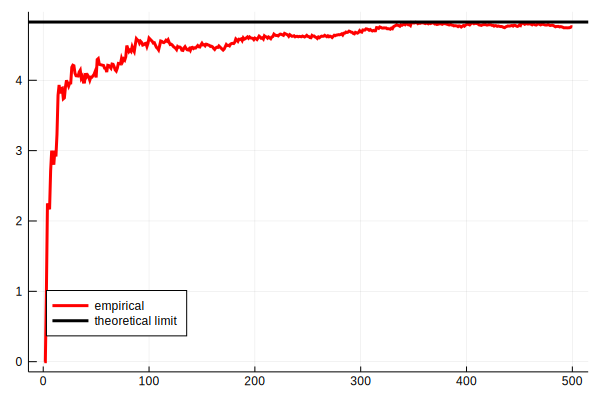

In [264]:
N = 500
w = rand(law, N+1, N+1)
res1 = m_G(w)
diag = [res1[i+1,i+1]/i for i in 1:N]
plot(1:N, diag, lw = 3, color = "red", legend=:bottomleft, label = "empirical")
hline!([γ], lw = 3, color = "black", label = "theoretical limit")

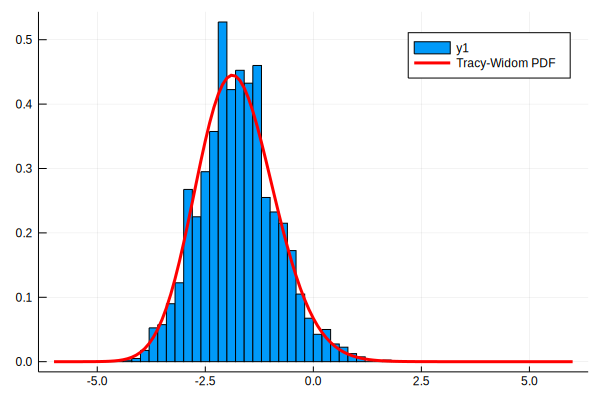

In [280]:
norm_res = (res .- γ*N) ./ (σ * N^(1/3))
histogram(norm_res, normalize=true, bins=-5:0.2:5)
plot!(xs, TW_pdf, lw = 3, color = "red", label = "Tracy-Widom PDF")

In [ ]:
## Add Interact plot
## Find the right normalization
## Add option to specify randomness